In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# 데이터 준비
df = pd.read_csv("data/bsmax_0_1", sep='\t')
print(df.head())
print(df.shape)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.FloatTensor(sequences), torch.FloatTensor(targets)

seq_length = 10  # 시퀀스 길이
data = df.values

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
sequences, targets = create_sequences(data_normalized, seq_length)
print(sequences.shape, targets.shape)

train_sequences, test_sequences, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, shuffle=True)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = train_sequences.shape[2]
hidden_size = 100  # 은닉층 뉴런 수를 증가
num_layers = 3  # 은닉층 수를 증가
output_size = train_targets.shape[1]

model = GRU(input_size, hidden_size, num_layers, output_size)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 학습률을 낮게 설정

# 학습
num_epochs = 200  # 에포크 수를 증가
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_sequences)
    loss = criterion(outputs, train_targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_sequences)
            test_loss = criterion(test_outputs, test_targets)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(test_sequences)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

# 예측 결과 시각화 및 저장
predicted = test_outputs.cpu().numpy()
actual = test_targets.cpu().numpy()

# headers에 맞게 데이터를 정규화 해제합니다.
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)
header = "ymd	init	rtn	avg	dev	bkmax	skmax	bomega	somega	bpri	bfor	bmom	bc	bpmax	bmax	bmomn	bcn	bpmaxn	bmaxn	spri	sfor	smom	sc	spmax	smax	smomn	scn	spmaxn	smaxn".split("\t")


/var/folders/0g/jdmkl_m54nv630zttylbx6b80000gn/T/ipykernel_909/3212459087.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.FloatTensor(sequences), torch.FloatTensor(targets)


     ymd    init   rtn     avg   dev  bkmax  skmax  bomega  somega   bpri  \
0  90323  192333  -500  192670  1452     12     14  -0.002   0.002 -0.277   
1  90324  192562 -4848  187788  1542      5      6   0.020   0.039 -0.385   
2  90325  188812 -2098  187049   574      4      7   0.001   0.001 -0.179   
3  90326  186556   944  187753   517      6      8   0.001  -0.001 -0.323   
4  90327  187794 -2982  185802   756     10     10  -0.001   0.001 -0.402   

   ...   spri      sfor      smom      sc    spmax    smax   smomn    scn  \
0  ... -0.267  3284.428   412.228   9.682  315.230  23.000  10.655  0.052   
1  ... -0.404  6665.924  1028.882   8.776  721.892  30.500  10.915  0.032   
2  ... -0.228  2723.411   315.232  11.061  151.065  19.429   9.821  0.065   
3  ... -0.205  1627.165   208.041   8.732  216.675  23.125   8.048  0.056   
4  ... -0.129  2233.416   208.066  11.381   91.132  22.300   7.397  0.073   

     spmaxn  smaxn  
0  1293.851  0.000  
1  1239.855  6.333  
2   945.091

In [3]:
# 결과 저장 폴더가 없으면 생성
os.makedirs('result', exist_ok=True)

# 데이터 각각 시각화 및 저장
for i in range(1, len(header)):
    plt.figure(figsize=(12, 6))
    plt.plot(actual[:, i], label='Actual')
    plt.plot(predicted[:, i], label='Predicted')
    plt.title(header[i])
    plt.legend()
    plt.savefig(f'result/gru_{header[i]}.png')
    plt.close()  # 플롯을 닫아서 메모리 해제

Test Loss: 0.0571
Feature names length: 29
Feature importances length: 29


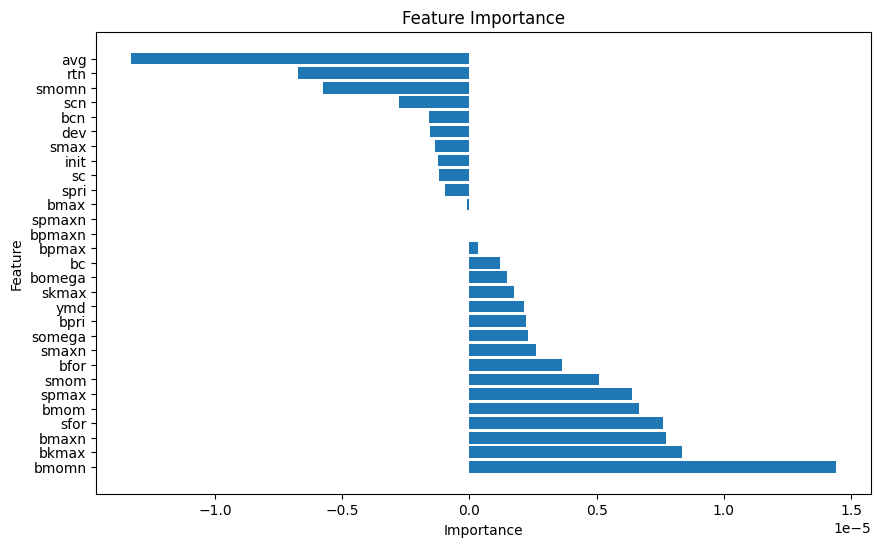

In [5]:
# Permutation Feature Importance 계산
def permute_feature_importance(model, test_sequences, test_targets, base_loss, feature_idx):
    permuted_sequences = test_sequences.clone()
    permuted_sequences[:, :, feature_idx] = permuted_sequences[:, torch.randperm(permuted_sequences.size(1)), feature_idx]
    with torch.no_grad():
        permuted_outputs = model(permuted_sequences)
        permuted_loss = criterion(permuted_outputs, test_targets)
    return permuted_loss.item() - base_loss.item()

model.eval()
with torch.no_grad():
    base_test_outputs = model(test_sequences)
    base_test_loss = criterion(base_test_outputs, test_targets)
    print(f'Test Loss: {base_test_loss.item():.4f}')

feature_importances = []
for i in range(input_size):
    importance = permute_feature_importance(model, test_sequences, test_targets, base_test_loss, i)
    feature_importances.append(importance)

# 헤더에 맞게 변수 이름 설정
feature_names = header[0:input_size+1]
print(f"Feature names length: {len(feature_names)}")
print(f"Feature importances length: {len(feature_importances)}")

if len(feature_names) != len(feature_importances):
    raise ValueError("Feature names and feature importances length do not match. Please check the input data and header.")

# 중요도 시각화 및 저장
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('result/gru_feature_importance.png')
plt.show()